**Todo**:
1. Transform features (must understand the sensor data before)
2. Remove unnecessary features (using what? correlation matrix, random forest, pca, ...)
3. Combine different regression models (ensemble model) to evaluate the test dataset
3. Try Deep Learning (Autoencoder, Vanilla... on google colab or on gpu server if you have an access)
4. Look into paperswithcode website for experimental model
5. Think about how to make a learning model explainable for decision
6. Do some EDAs, don't have to be fancy or anything
7. Post random code on the dacon website; uploading a code is part of the grade 


possibly more...

### Import Libraries

In [2]:
!pip install optuna
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.7 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 209 kB 61.0 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 66.0 MB/s 
     |████████████████████████████████| 147 kB 58.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=78b9f0aec269f83668f3d066a17148010757e666bd22925d77d7ba46ee6e8daf
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import random
import os
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from hyperopt import fmin, hp, tpe, Trials
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [6]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [7]:
def check_for_NAs(df, show=False):
    """
    @Description: checks for the NAs in the dataframe
    @Param1: df, pandas dataframe
    @Param2: show, boolean indicating whether NaN data are also necessary as a part of the output
    @Return: name of the columns with NaN
    """
    nan_values = df.loc[:, df.isnull().any()]
    if show:
        return df[df.isna().any(axis=1)]
    return list(nan_values.columns)

In [8]:
def check_for_label_bound(df, labels, bound):
    """
    @Description: check bound is inbetween min and max
    @Param1: df, pandas dataframe
    @Param2: labels, list of column names 
    @Param3: thres: list of bounds
    @Return: names of the columns not within the bound
    """
    n = len(labels)
    result = []
    for idx in range(n):
        col = labels[idx]
        thres = bound[idx]
        extracted_column = df[col]
        if not extracted_column.between(thres[0], thres[1]).all():
            result.append(labels[idx])
    if len(result) == 0:
        print('everything is within the bound')
    return result

In [9]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in train_x.columns:
        if train_x[col].var() == 0:
            result.append(col)
    return result

In [10]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [11]:
def adjacent_histogram_boxplot(feature_var, figsize = (7, 5)):
    """
    @Description: plot histogram and boxplot in next to each other
    @Param1: feature_var, pandas series 
    @Param2: figsize, size of the figure 
    """
    fig, (hist_plot, box_plot) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':(.85,.15)}, figsize=figsize)
    sns.distplot(feature_var, kde=True, ax=hist_plot, kde_kws= {"linewidth":1.5}) 
    sns.boxplot(feature_var, ax=box_plot, linewidth = 1, width = 0.5)
    hist_plot.set_ylabel('')    
    hist_plot.set_xlabel('')
    box_plot.set_xlabel('')
    hist_plot.tick_params(labelsize=8)
    box_plot.tick_params(labelsize=8)
    fig.suptitle(feature_var.name, fontsize = 10)
    hist_plot.axvline(np.mean(feature_var),color='red',linestyle='-',lw = 1.5)
    hist_plot.axvline(np.median(feature_var),color='green',linestyle='--',lw = 1.5)
    

In [12]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [13]:
# ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
#       'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
#       'Y_11', 'Y_12', 'Y_13', 'Y_14']
# ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
#              [7, 19], [22, 36.5], [-19.2, 19], 
#              [2.4, 4], [-29.2, -24], [-29.2, -24],
#              [-30.6, -20], [19.6, 26.6], [-29.2, -24],
#              [-29.2, -24], [-29.2, -24]]

### Load Dataset

In [14]:
# 구글 드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
train_df = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/train.csv')
test_x = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

### Exploratory Data Analysis

In [16]:
train_x.iloc[:, :10].describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


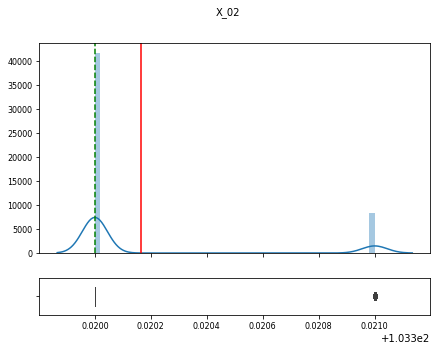

In [17]:
x01 = train_x.iloc[:, :10].iloc[:, 1]
adjacent_histogram_boxplot(x01)

In [18]:
train_x.iloc[:, 10:20].describe()

,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,0.000366,4.373228,0.143335,13.372201,13.381914,13.463860,13.512589,13.449263,3.240229,3.184493
std,0.014145,0.021806,0.025334,0.029865,0.029468,0.036741,0.023436,0.029093,0.110482,0.105266
min,0.000000,4.270000,0.050000,13.150000,13.230000,13.260000,13.410000,13.260000,2.860000,2.830000
25%,0.000000,4.360000,0.130000,13.350000,13.360000,13.440000,13.500000,13.430000,3.160000,3.100000
50%,0.000000,4.370000,0.140000,13.370000,13.380000,13.470000,13.510000,13.450000,3.220000,3.180000
75%,0.000000,4.390000,0.160000,13.390000,13.410000,13.490000,13.530000,13.470000,3.310000,3.270000
max,0.700000,4.490000,0.280000,13.490000,13.500000,13.610000,13.610000,13.570000,3.750000,3.670000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


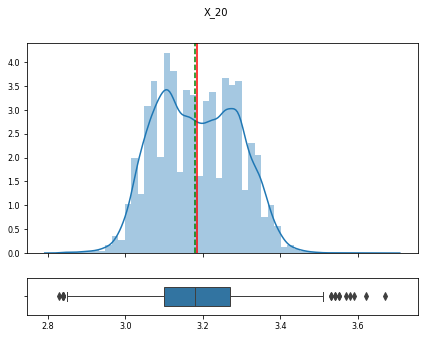

In [19]:
x11 = train_x.iloc[:, 10:20].iloc[:, 9]
adjacent_histogram_boxplot(x11)

In [20]:
train_x.iloc[:, 20:30].describe()

,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30
count,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,3.174270,3.232673,1.0,2.115674,2.093895,2.090377,2.098249,2.118594,2.173727,1.378994
std,0.106868,0.108981,0.0,0.032440,0.033148,0.038512,0.038056,0.042782,0.046689,0.030412
min,2.830000,2.850000,1.0,1.830000,1.960000,1.980000,1.990000,1.930000,2.020000,0.570000
25%,3.090000,3.140000,1.0,2.090000,2.070000,2.060000,2.070000,2.090000,2.140000,1.370000
50%,3.160000,3.230000,1.0,2.120000,2.090000,2.090000,2.090000,2.120000,2.170000,1.370000
75%,3.250000,3.320000,1.0,2.140000,2.120000,2.120000,2.120000,2.140000,2.200000,1.380000
max,3.680000,3.790000,1.0,2.350000,2.350000,2.350000,2.350000,2.350000,2.360000,2.110000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


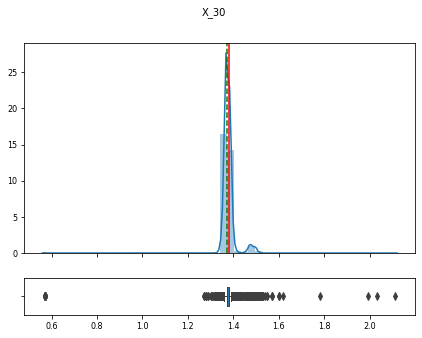

In [21]:
x21 = train_x.iloc[:, 20:30].iloc[:, 9]
adjacent_histogram_boxplot(x21)

In [22]:
train_x.iloc[:, 30:40].describe()

,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,1.571141,1.362929,1.595723,12.950271,12.920343,12.941728,12.919139,-15.903737,-15.889576,-16.572162
std,0.074520,0.029945,0.108028,0.044030,0.052238,0.047830,0.052292,0.595420,0.746665,0.344486
min,0.600000,0.570000,0.610000,12.840000,12.810000,12.840000,12.810000,-17.090000,-17.090000,-17.720000
25%,1.530000,1.350000,1.550000,12.920000,12.870000,12.900000,12.870000,-16.160000,-16.160000,-16.810000
50%,1.550000,1.360000,1.570000,12.960000,12.920000,12.950000,12.910000,-15.990000,-15.990000,-16.640000
75%,1.600000,1.370000,1.610000,12.990000,12.970000,12.980000,12.970000,-15.750000,-15.750000,-16.400000
max,7.210000,2.450000,7.810000,13.080000,13.090000,13.090000,13.080000,32.230000,-2.650000,-14.800000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


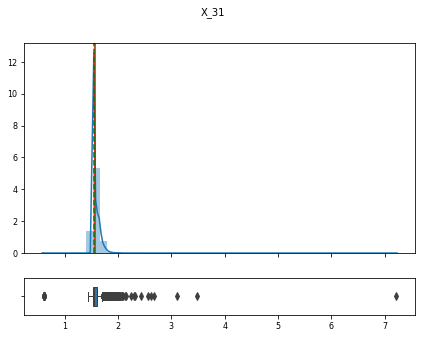

In [23]:
x31 = train_x.iloc[:, 30:40].iloc[:, 0]
adjacent_histogram_boxplot(x31)

In [24]:
train_x.iloc[:, 40:50].describe()

,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.0,39607.0,39607.000000,39607.000000
mean,21.186992,21.059334,21.203705,21.160107,0.154567,1468.275305,1.0,1.0,16676.913639,130.774557
std,0.031128,0.040288,0.047211,0.042176,0.046968,2.121517,0.0,0.0,8584.427420,5.989845
min,20.730000,20.790000,20.800000,20.930000,0.000000,1457.000000,1.0,1.0,3341.830000,21.800000
25%,21.170000,21.030000,21.170000,21.130000,0.120000,1469.000000,1.0,1.0,13093.930000,126.948571
50%,21.190000,21.060000,21.200000,21.160000,0.150000,1469.000000,1.0,1.0,15273.330000,130.723378
75%,21.210000,21.090000,21.240000,21.190000,0.190000,1469.000000,1.0,1.0,17560.180000,134.538998
max,21.620000,21.440000,21.410000,21.320000,0.420000,1469.000000,1.0,1.0,114563.630000,162.619458


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


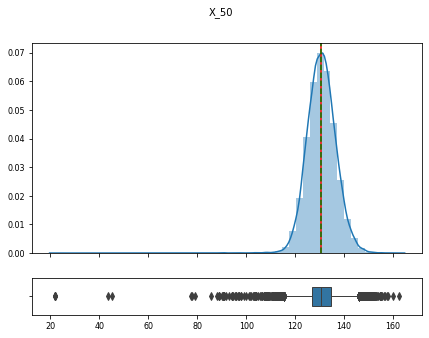

In [25]:
x41 = train_x.iloc[:, 40:50].iloc[:, 9]
adjacent_histogram_boxplot(x41)

In [26]:
train_x.iloc[:, 50:].describe()

,X_51,X_52,X_53,X_54,X_55,X_56
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,131.457418,138.587595,127.992420,128.014110,137.884711,128.441119
std,5.934313,6.469813,5.713153,5.433958,6.552101,5.444245
min,21.910000,23.100000,21.330000,21.340000,22.980000,21.410000
25%,127.669758,134.475401,124.374525,124.697879,133.744103,125.134713
50%,131.352856,138.525575,128.020010,128.098728,137.900952,128.414501
75%,135.170761,142.702448,131.618662,131.487423,142.073102,131.839764
max,194.513195,173.438623,152.406630,175.052891,170.155980,155.277538


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


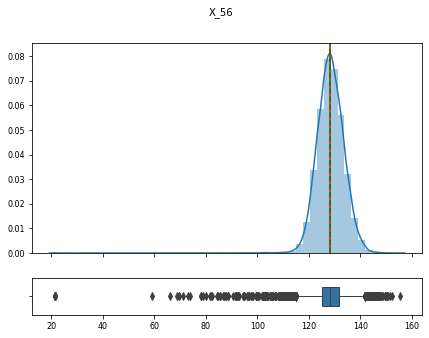

In [27]:
x51 = train_x.iloc[:, 50:].iloc[:, 5]
adjacent_histogram_boxplot(x51)

### Feature Selection
Need to spend more time on this!  

Must understand the nature of the data (sensor) to get better performance

In [29]:
train_df = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/train.csv')
test_x = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

cols_with_zero_variance = zero_variance(train_x)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)

test_x = test_x.drop(cols_with_zero_variance, axis = 1)

highly_correlated = [i[1] for i in get_top_correlation(train_x, 7).index]
train_x = train_x.drop(highly_correlated, axis = 1)

test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

In [30]:
results = []
rfg = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
feature_names = train_x.columns
rfg.fit(train_x, train_y)
for feature, score in zip(feature_names, rfg.feature_importances_):
    if score < np.mean(rfg.feature_importances_):
        results.append(feature)
        
train_x = train_x.drop(results, axis = 1)
test_x = test_x.drop(results, axis = 1)

In [31]:
train_x

,X_03,X_05,X_07,X_08,X_09,X_19,X_20,X_34,X_37,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,67.47,101.892,29.45,62.38,245.71,3.11,3.17,12.99,12.99,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,65.17,101.944,28.73,61.23,233.61,2.97,3.11,12.92,12.93,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,64.07,103.153,28.81,105.77,272.20,3.04,3.04,12.97,13.00,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,67.57,101.971,28.92,115.21,255.36,3.05,3.01,12.91,12.92,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,63.57,101.981,29.68,103.38,241.46,3.04,3.07,12.96,12.96,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,62.27,103.150,30.20,77.83,298.05,3.20,3.03,12.89,12.90,60630.73,129.965741,130.807148,133.481737,125.273130,121.780933,133.780110,129.029812
39603,62.77,102.021,29.21,102.25,270.67,3.15,3.06,12.88,12.86,60763.43,127.633885,120.158764,142.667802,122.465490,122.987209,143.090741,122.811413
39604,64.67,103.144,29.96,102.61,198.07,3.23,3.09,12.98,12.81,8813.33,132.501286,136.893025,134.419328,129.115431,130.920147,140.489232,119.166699
39605,63.67,102.025,30.30,112.60,275.52,3.18,3.01,12.91,12.97,62222.33,128.189679,121.495930,141.288011,130.141676,125.518825,136.603634,124.525929


### Train
Train dataset is again splitted into train and validation set

In [32]:
def evaluate_lgb(params, x_train, y_train, x_test, y_test):
    model = MultiOutputRegressor(LGBMRegressor(objective='regression', n_jobs=-1, **params))
    model.fit(x_train, y_train)    
    pred = model.predict(x_test)
    nrmse = lg_nrmse(y_test, pred)
    return nrmse

In [33]:
train_X, validation_X, train_Y, validation_Y = train_test_split(train_x, train_y, test_size = 0.2)


In [34]:
lgb_params_space = {
    'max_depth':        hp.choice('max_depth',        np.arange(3, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 9, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.2, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'n_estimators':     100,
    'num_leaves':       50,
    'bagging_fraction': hp.uniform("bagging_fraction", 0, 1.0),
}

In [35]:
hyperopt_objective = lambda params: evaluate_lgb(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

NameError: ignored

In [ ]:
best_params

### Inference

In [ ]:
model = MultiOutputRegressor(LGBMRegressor(**best_params))
model.fit(train_x, train_y)
preds = model.predict(test_x)

In [ ]:
pd.DataFrame(preds)

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit

### Save Prediction

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
submit.to_csv('./submission.csv')